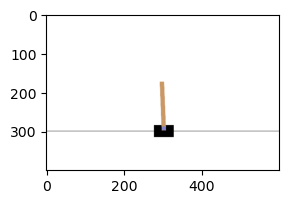

In [2]:
import gym
#定义环境
class MyWrapper(gym.Wrapper):
    def __init__(self):
        env=gym.make('CartPole-v1',render_mode='rgb_array')
        super().__init__(env)
        self.env=env
        self.step_n=0
    def reset(self):
        state,_=self.env.reset()
        self.step_n=0
        return state
    def step(self,action):
        state,reward,terminated,truncated,info=self.env.step(action)
        over=terminated or truncated

        #限制最大步数
        self.step_n+=1
        if self.step_n>=200:
            over=True

        #没坚持到最后，扣分
        if over and self.step_n<200:
            reward=-1000

        return state,reward,over
    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt 
        plt.figure(figsize=(3,3))
        plt.imshow(self.env.render())
        plt.show()
env=MyWrapper()
env.reset()
env.show()

In [5]:
#定义DQN，评估状态下每个动作的价值
import torch
model=torch.nn.Sequential(
    torch.nn.Linear(4,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,2)
    )
model

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
)

In [6]:
from IPython import display
import random

#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:

        #play中计算动作的部分
        action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
        if random.random() < 0.1:
            action = env.action_space.sample()


        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state
        
        if show:
            display.clear_output(wait=True)
            env.show()
    return data, reward_sum


play()[-1]

-89.0

In [7]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
        action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0]

C:\Users\17422\AppData\Local\Temp\ipykernel_8212\2282743005.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)


(207,
 (array([-0.01457732,  0.00250962,  0.02774999, -0.04948017], dtype=float32),
  1,
  1.0,
  array([-0.01452713,  0.1972229 ,  0.02676039, -0.33328018], dtype=float32),
  False))

In [8]:
#训练
def train():
    model.train()
    optimizer=torch.optim.Adam(model.parameters(),lr=2e-4)
    loss_fn=torch.nn.MSELoss()

    #共更新N轮数据
    for epoch in range(1000):
        pool.update()
        #每次更新后，训练N次
        for i in range(200):
            #采样N条数据
            state,action,reward,next_state,over=pool.sample()


            #计算value
            value=model(state).gather(dim=1,index=action)
            #计算target
            with torch.no_grad():
                target=model(next_state)

            
            target=target.max(dim=1)[0].reshape(-1,1)
            target=target*0.99*(1-over)+reward
            
            loss=loss_fn(value,target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch%100==0:
            test_result=sum(play()[-1] for _ in range(20))/20
            print(epoch,len(pool),test_result)

train()

0 410 -65.1
100 20000 176.4
200 20000 25.4
300 20000 188.25
400 20000 200.0
500 20000 200.0
600 20000 194.65
700 20000 200.0
800 20000 200.0
900 20000 200.0


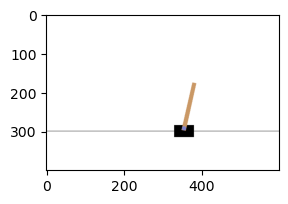

-50.0

In [12]:
play(True)[-1]